In [1]:
from colomoto.minibn import *
import pandas as pd

In [2]:
output_prefix = "../ground-truth/"
!mkdir -p {output_prefix}

### Load synthetic Boolean network and associated configurations

# computing graph layout...


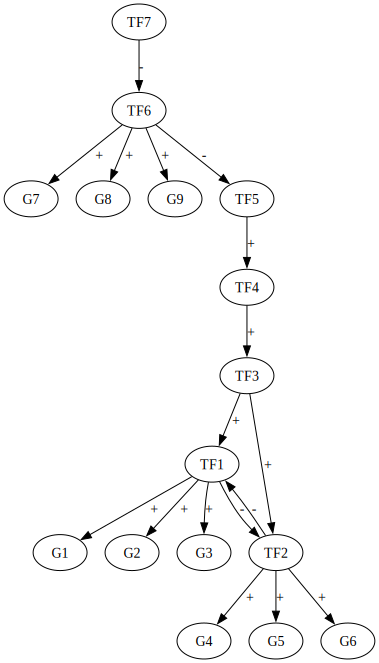

In [3]:
f = BooleanNetwork.load("boolean-network.bnet")
f_ig = f.influence_graph()
f_ig

In [4]:
f.save(output_prefix + "boolean-network.bnet")

In [5]:
with open(output_prefix + "influence-graph.sif", "w") as fp:
    for a, b, d in f_ig.edges(data=True):
        print(a, "activates" if d["sign"] > 0 else "inhibits", b, file=fp)

In [6]:
initial_state = f.zero()
for node in ["TF7", "TF6", "G7", "G8", "G9"]:
    initial_state[node] = 1
initial_state

{'G1': 0,
 'G2': 0,
 'G3': 0,
 'G4': 0,
 'G5': 0,
 'G6': 0,
 'G7': 1,
 'G8': 1,
 'G9': 1,
 'TF1': 0,
 'TF2': 0,
 'TF3': 0,
 'TF4': 0,
 'TF5': 0,
 'TF6': 1,
 'TF7': 1}

In [7]:
class PriorityDynamics(UpdateModeDynamics):
    def __call__(self, x):
        y = self.model(x)   # f(x)
        C = {a for a in self.nodes if y[a] != x[a]}
        genes = list(sorted(a for a in C if a.startswith("G")))
        if genes:
            z = x.copy()
            z[genes[0]] = y[genes[0]]
            yield z
            return
        for a in C:
            z = x.copy()
            z[a] = y[a]
            yield z

# computing graph layout...


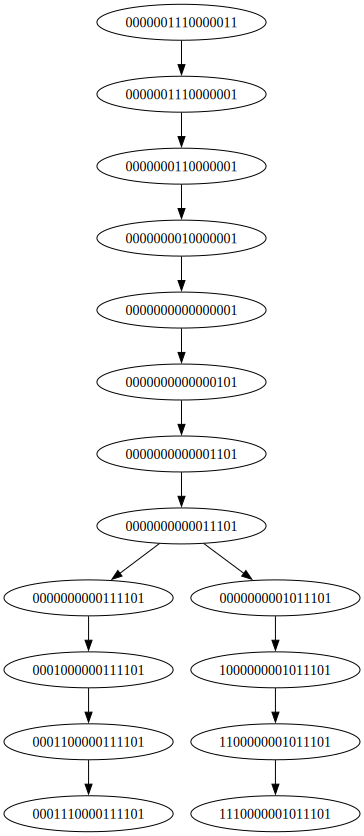

In [19]:
dynamics = PriorityDynamics(f)
stg = dynamics.partial_dynamics(initial_state)
stg

In [20]:
def node_to_dict(dyn, n):
    return {a: int(v) for (a,v) in zip(dyn.nodes, n)}

def make_labels(G):
    assert nx.is_tree(G)
    root = next(n for (n,ind) in G.in_degree() if ind == 0)
    G.nodes()[root]["label"] = "init" if G.out_degree(root) > 0 else "steady"
    ids = {"switch": 0, "steady": 0}
    def label_tree(root, begin):
        for n in G.successors(root):
            label_branch(n, begin)
    def label_branch(n, begin):
        global switch_id
        global steady_id
        if G.out_degree(root) != 1:
            assert NotImplementedError
        final_branch = len(list(nx.attracting_components(G.subgraph(nx.descendants(G, n))))) == 1
        final_key = "steady" if final_branch else "switch"
        ids[final_key] += 1
        dest = f"{final_key}{ids[final_key]}"
        i = 1
        while G.out_degree(n) == 1:
            label = f"{begin}_to_{dest}_{i}"
            G.nodes()[n]["label"] = label
            n = list(G.successors(n))[0]
            i += 1
        G.nodes()[n]["label"] = dest
        label_tree(n, dest)
    label_tree(root, "init")
    return G

def make_traj_df(f, initial_state):
    dyn = PriorityDynamics(f)
    stg = dyn.partial_dynamics(initial_state)
    make_labels(stg)
    return pd.DataFrame.from_dict({d["label"]: node_to_dict(dyn, n) for n, d in stg.nodes(data=True)}).T

# computing graph layout...


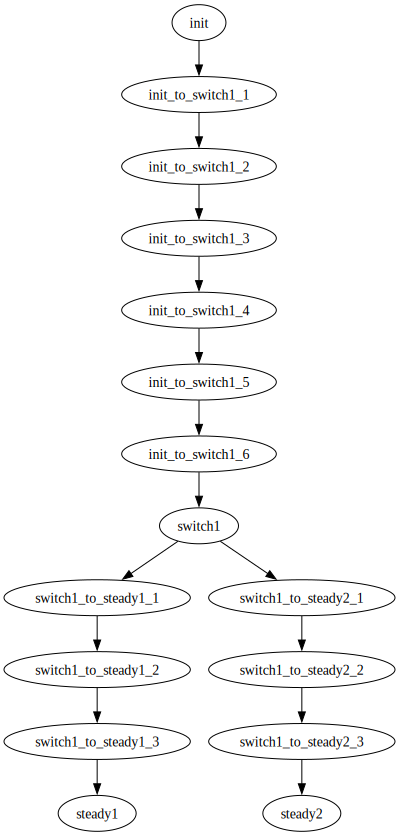

In [21]:
make_labels(stg)

In [22]:
def make_mutant(spec):
    print(spec)
    f_mut = f.copy()
    for k, v in spec.items():
        f_mut[k] = v
    x0 = initial_state | spec
    label = "".join(f"{k}{'UP' if v else 'KO'}" for k,v in spec.items()) or "wt"
    traj_df = make_traj_df(f_mut, x0)
    traj_df.to_csv(f"{output_prefix}{label}-boolean-trajectories.csv")
    return traj_df.index

In [23]:
mutants = [{}, {"TF7": 0}, {"TF5": 0}, {"TF1": 0}, {"TF2": 0}, {"TF1": 0, "TF2": 0}, {"G8": 1, "G1": 0}]
for spec in mutants:
    print(make_mutant(spec))

{}
Index(['init', 'init_to_switch1_1', 'init_to_switch1_2', 'init_to_switch1_3',
       'init_to_switch1_4', 'init_to_switch1_5', 'init_to_switch1_6',
       'switch1', 'switch1_to_steady1_1', 'switch1_to_steady2_1',
       'switch1_to_steady1_2', 'switch1_to_steady1_3', 'steady1',
       'switch1_to_steady2_2', 'switch1_to_steady2_3', 'steady2'],
      dtype='object')
{'TF7': 0}
Index(['steady'], dtype='object')
{'TF5': 0}
Index(['init', 'init_to_steady1_1', 'init_to_steady1_2', 'init_to_steady1_3',
       'steady1'],
      dtype='object')
{'TF1': 0}
Index(['init', 'init_to_steady1_1', 'init_to_steady1_2', 'init_to_steady1_3',
       'init_to_steady1_4', 'init_to_steady1_5', 'init_to_steady1_6',
       'init_to_steady1_7', 'init_to_steady1_8', 'init_to_steady1_9',
       'init_to_steady1_10', 'steady1'],
      dtype='object')
{'TF2': 0}
Index(['init', 'init_to_steady1_1', 'init_to_steady1_2', 'init_to_steady1_3',
       'init_to_steady1_4', 'init_to_steady1_5', 'init_to_steady1_6',
  